# Прогнозирование индекса промышленного производства

Для предсказания изменений в индексе промышленного производства применяется методика градиентного бустинга с использованием библиотеки CatBoost

### Определяющие признаки:
- Новостной индекс ЦБ (news)
- Индекс цен на электроэнергию в первой ценовой зоне (consumer_price)
- Промышленность (cb_monitor)
- Индикатор бизнес климата (bussines_clim)
- Курс рубля (curs)
- Погрузка на сети РЖД (rzd)

Каждый признак имеет разный лаг эффекта на экономику. Поэтому для различных прогнозов будут созданы столбцы с лагами __(с постфиксом lag_i)__ Более того, при прогнозе более чем на месяц, новостной индекс ЦБ имеет все большую предсказательную силу

Для каждого из трех прогнозируемых периодов обучается отдельная модель, поскольку лаг-переменные, отражающие временные сдвиги в воздействии факторов, фактически представляют собой новые признаки

## Импорт библиотек и установка зависимостей

In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/pycups-2.0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/PyPDF3-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [183]:
import pandas as pd
import datetime
import numpy as np

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Импорт данных

In [19]:
df = pd.read_csv('.././data/preprocessed_ipp_factors.csv')

df.date = pd.to_datetime(df.date).dt.date

In [20]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd
0,1/31/2015,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6
1,2/28/2015,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5
2,3/31/2015,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0


# Добавление столбцов с лаггом

### Лаги для признаков:
- __Новостной индекс ЦБ (news):__ 1 месяц
- __Индекс цен на электроэнергию в первой ценовой зоне (consumer_price):__ 0 месяцев
- __Промышленность (cb_monitor):__ 2 месяца
- __Индикатор бизнес климата (bussines_clim):__ 2 месяца
- __Курс рубля (curs):__ 0 месяцев
- __Погрузка на сети РЖД (rzd):__ 1 месяц

In [21]:
df.head(1)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd
0,1/31/2015,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6


In [22]:
for i in range(1, 3 + 1):
    df[f'goal_lag_{i}'] = df['goal'].shift(i) ** 2
    df[f'news_lag_{i}'] = df['news'].shift(i)
    df[f'bussines_clim_lag_{i}'] = df['bussines_clim'].shift(i)
    df[f'cb_monitor_lag_{i}'] = df['cb_monitor'].shift(i)
    df[f'rzd_lag_{i}'] = df['rzd'].shift(i)

df = df.fillna(method='pad')

In [23]:
df.head(3)

,date,goal,news,consumer_price,cb_monitor,bussines_clim,curs,rzd,goal_lag_1,news_lag_1,...,goal_lag_2,news_lag_2,bussines_clim_lag_2,cb_monitor_lag_2,rzd_lag_2,goal_lag_3,news_lag_3,bussines_clim_lag_3,cb_monitor_lag_3,rzd_lag_3
0,1/31/2015,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/28/2015,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5,10261.69,-1.551464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/31/2015,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0,9960.04,-1.756337,...,10261.69,-1.551464,-8.734671,-20.468123,96.6,NaN,NaN,NaN,NaN,NaN


## Корреляция ИПП с признаками (с лаггом)

In [184]:
corr_matrix =  df[['goal'] + exog_var].corr()

<Axes: >

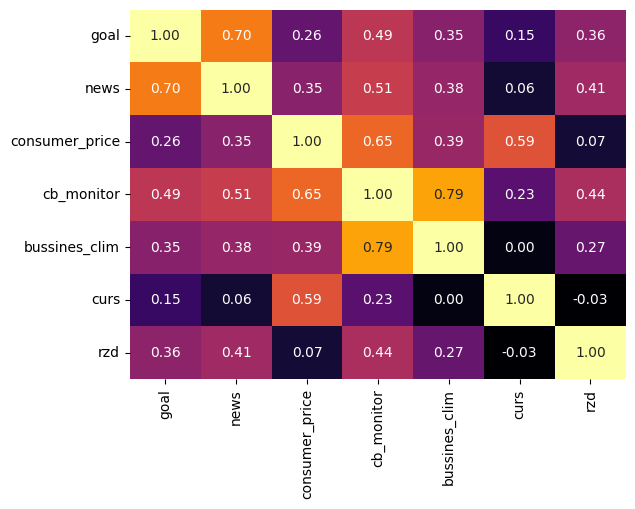

In [204]:
# fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

sns.heatmap(
    df.iloc[:, 1:8].corr(),
    fmt=".2f",
    # ax=ax,
    annot=True,
    cmap='inferno',
    cbar=False
)

Заметим, что cb_monitor и bussines_clim сильно коррелируемы: попробуем с помощью метода главных компонентов выделить главную компоненту

# Сделаем прогноз на 1 месяц

Для этого обучим модель по следующим признакам:

In [60]:
from sklearn.model_selection import train_test_split

экзогенные переменные для прогнозирования на 1 месяц вперед

In [61]:
exog_var = ['news_lag_1', 'consumer_price', 'cb_monitor_lag_2', 'bussines_clim_lag_1', 'curs', 'rzd_lag_1']

Поделим на обучающую и тестовую выборку 80/20

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(df[exog_var], df.goal, test_size=0.2, random_state=42)

In [64]:
model = CatBoostRegressor(
        iterations=4,
        learning_rate=1,
        depth=4,
        verbose=False, 
        loss_function='RMSE',
        l2_leaf_reg = 1
    )

In [65]:
grid = {
    'iterations':    [2, 4, 6, 8, 15], 
    'depth':         [3, 5, 6, 8],
    'l2_leaf_reg':   [0.01,  0.1,  0.5, 1, 1.5],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}

In [66]:
res = model.grid_search(
    grid, X_train, Y_train, 
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0,
    # cv=tscv
)


bestTest = 101.4755252
bestIteration = 1


bestTest = 99.6435484
bestIteration = 1


bestTest = 82.23685212
bestIteration = 1


bestTest = 25.00666426
bestIteration = 1


bestTest = 3.189011601
bestIteration = 1


bestTest = 101.4768887
bestIteration = 1


bestTest = 99.65706844
bestIteration = 1


bestTest = 82.36055268
bestIteration = 1


bestTest = 25.37480265
bestIteration = 1


bestTest = 3.302417487
bestIteration = 1


bestTest = 101.4825031
bestIteration = 1


bestTest = 99.71276281
bestIteration = 1


bestTest = 82.87275891
bestIteration = 1


bestTest = 27.01370107
bestIteration = 1


bestTest = 6.575749089
bestIteration = 0


bestTest = 101.4887021
bestIteration = 1


bestTest = 99.77428718
bestIteration = 1


bestTest = 83.44193388
bestIteration = 1


bestTest = 28.95937926
bestIteration = 1


bestTest = 10.11518915
bestIteration = 1


bestTest = 101.4942138
bestIteration = 1


bestTest = 99.8290079
bestIteration = 1


bestTest = 83.9500117
bestIteration = 1


bestTest = 30

In [71]:
res['params']

{'depth': 3, 'learning_rate': 0.5, 'l2_leaf_reg': 0.1, 'iterations': 15}

In [72]:
model = CatBoostRegressor(**res['params'], verbose = False)
model.fit(X_train, Y_train)

### Качество модели:

In [75]:
from sklearn.metrics import mean_squared_error, r2_score

In [76]:
train_predict = model.predict(X_train)
print(f'mse train: {np.round(mean_squared_error(Y_train, train_predict), 3)}')
print(f'r2_score: {np.round(r2_score(Y_train, train_predict), 3)}')

mse train: 1.346
r2_score: 0.876


In [77]:
test_predict = model.predict(X_test)
mse_test = np.round(mean_squared_error(Y_test, test_predict), 3)
print('mse test', mse_test)

mse test 5.162


## Визуализация

(17986.0, 19908.0)

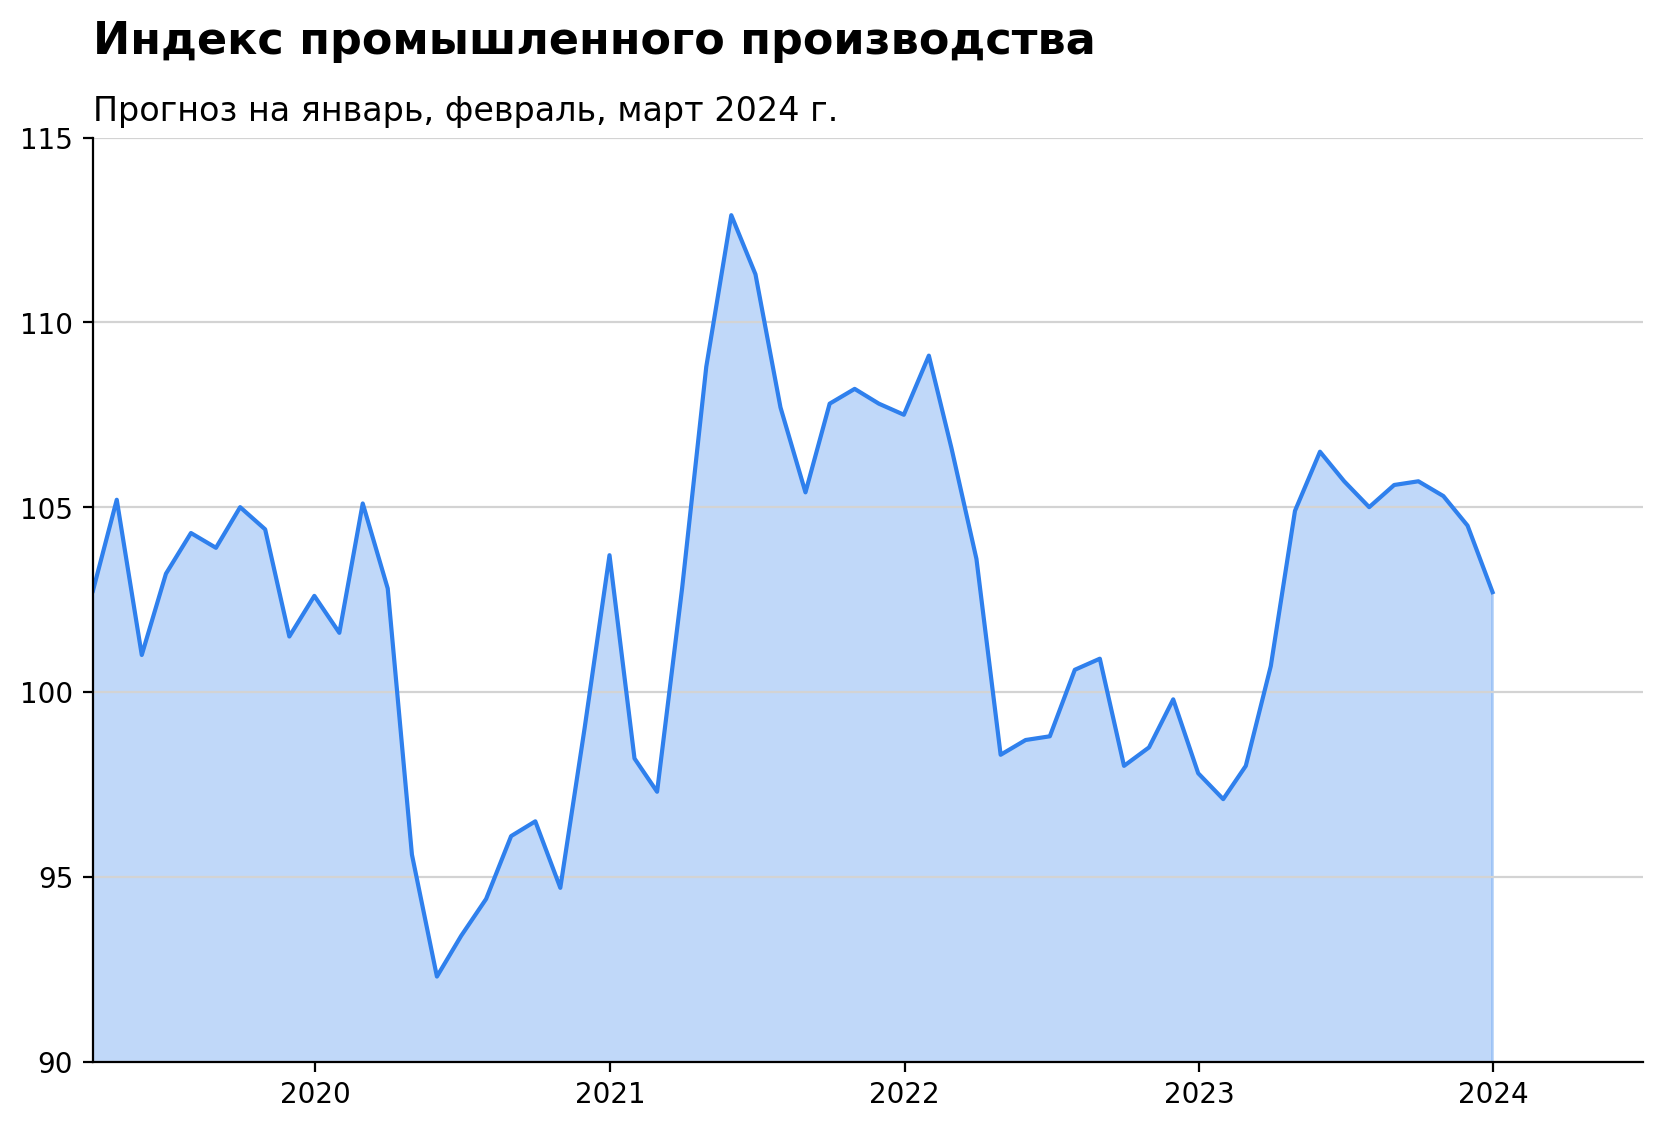

In [172]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

fig.text(y=.95, x=.125, s="Индекс промышленного производства",fontsize=16, fontweight="bold")
plt.title("Прогноз на январь, февраль, март 2024 г.",fontsize=12, loc='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y', color='lightgrey')

ax.plot(df.date, df.goal, color='#2F80ED')
ax.fill_between(df.date, df.goal, color='#2F80ED', alpha=0.3)

ax.set_ylim([90, 115])
ax.set_xlim([df.date.iloc[50], df.date.iloc[-1] + datetime.timedelta(days=31 * 6)])

In [6]:
def prep_forec(train, test):
    

    



    
    test_predict = pd.Series(test_predict, index=Y_test.index)
    my_forecast.loc[Y_test.index[0]].mf = test_predict.loc[Y_test.index[0]]

    for mlag in range (1, 3):
        data_forecast = my_forecast.index[mlag]
        print(data_forecast)
        exog_var = [i for i in conc_d_wda.columns if i[-5:] == f'lag_{mlag + 1}']
        exog_var_sort = conc_d_wda[['goal']+exog_var].corr()['goal'].sort_values(ascending=False).index[1:].tolist()
        print(exog_var)
        Y_train = train.goal
        X_train = train[exog_var_sort]
        Y_test = test.goal
        X_test = test[exog_var_sort]
        train_predict, test_predict, mse_test, model = make_gdb(Y_train, X_train, Y_test, X_test)
        my_forecast.loc[data_forecast].mf = model.predict(X_test[exog_var_sort])[mlag]

    conf_vect = np.linspace(1,1.5,3)
    my_forecast_v2 = my_forecast.copy()
    my_forecast_v2['ci_l'] = my_forecast_v2.mf+conf_vect
    my_forecast_v2['ci_h'] = my_forecast_v2.mf-conf_vect

    mrow = [Y_train.index[-1]]+[Y_train[-1]]*3
    my_forecast_v2 = my_forecast_v2.reset_index()
    my_forecast_v2.loc[4] = mrow
    my_forecast_v2 = my_forecast_v2.set_index('index').sort_index()

    date_rn = pd.date_range(start=my_forecast_v2.index[-1],
                            end = f'{my_forecast_v2.index[-1].year}-12-31', freq='MS')
    forec_last = pd.DataFrame([my_forecast_v2.mf[-1]]*len(date_rn), index = date_rn, columns=['mf'])
    
    conf_vect = np.linspace(1.5, 3, len(forec_last))
    forec_last['ci_l'] = forec_last.mf + conf_vect
    forec_last['ci_h'] = forec_last.mf - conf_vect

    return my_forecast_v2, forec_last

# 

In [7]:
def make_gdb(Y_train, X_train, Y_test, X_test):
    model = CatBoostRegressor(
        iterations=4,
        learning_rate=1,
        depth=4,
        verbose=False, 
        loss_function='RMSE',
        l2_leaf_reg = 1,
        # gpu=True
    )
    
    grid = {
        'iterations':    [2, 4, 6, 8, 15], 
        'depth':         [3, 5, 6, 8],
        'l2_leaf_reg':   [0.01, 0.1, 0.5, 1, 1.5],
        'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
    }


    res = model.grid_search(
        grid, X_train, Y_train, 
        calc_cv_statistics=True,
        search_by_train_test_split=True,
        refit=True,
        verbose=0,
        cv=tscv
    )
    
    model = CatBoostRegressor(**res['params'], verbose = False)
    print(res['params'])

    par_dict = {'depth': 6, 'iterations': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 2}
    model = CatBoostRegressor(**par_dict, verbose = False)

    model.fit(X_train, Y_train)
    preds = model.predict(X_train)

    train_predict = model.predict(X_train)
    print('mse train', np.round(mean_squared_error(Y_train, train_predict), 3))
    print('r2_score', np.round(r2_score(Y_train, train_predict), 3))

    test_predict = model.predict(X_test)
    mse_test = np.round(mean_squared_error(Y_test, test_predict), 3)
    print('mse test', mse_test)
    return train_predict, test_predict, mse_test, model

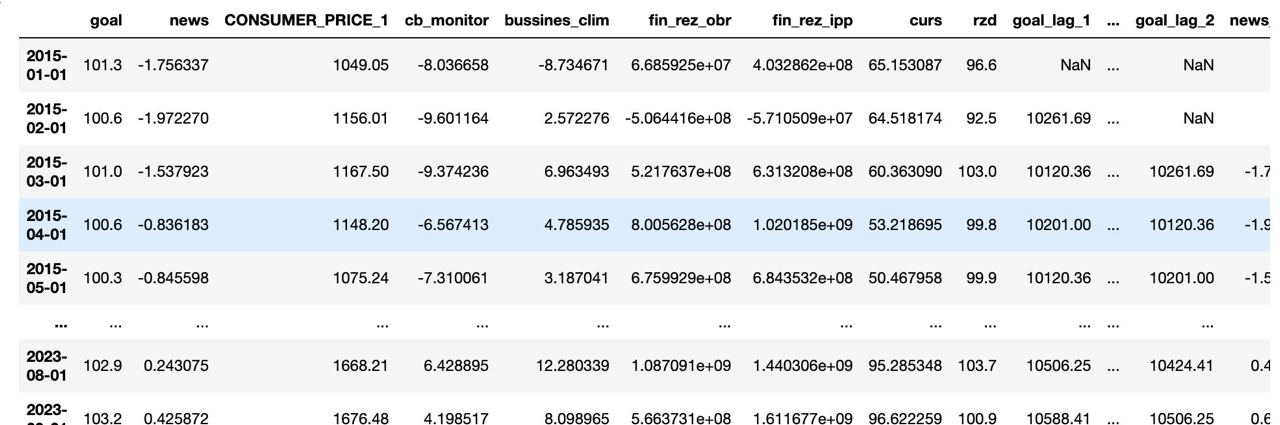